In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import ccf
import pmdarima as pm

ModuleNotFoundError: No module named 'statsmodels'

# Exercice Traitement et Analyse de série temporelle pour le cours GEO71021

## Lecture d'un csv et indexation de notre dataframe
La première étape est de lire notre csv pour l'ouvrir en dataframe pandas.

Ensuite, on veut utiliser nos colonnes Date et Time pour indexer notre dataframe au lieu d'un index numérique

In [3]:
filename = '/home/francis/Documents/UQAR/Cours/GEO71021/data_exemple/serpentine_20210308_15min.csv'

bd = pd.read_csv(filename,sep = ',', header = 0)
bd

,Date,Time,ValleyRecID,SW-IN,SW-OUT,LW-IN,LW-OUT,PAR-IN,PAR-OUT,AirTemp,RH,SnowDepth,PrecipRate,PrecipTotal,BucketWeight,PluvioStatus,WS,WD,WG,BatVolt
0,2020-11-13,13:00:09,Valley,76.6,9.7,281.4,328.1,190.9,11.6,2.67,59.7,-0.2,0.0,483.97,807.0,0,0.6,65.1,2.1,14.29
1,2020-11-13,13:15:09,Valley,104.7,7.3,283.3,326.4,149.9,9.2,2.65,60.0,-0.2,0.0,483.97,807.0,0,0.1,144.0,1.1,14.30
2,2020-11-13,13:30:09,Valley,53.8,5.7,284.3,325.7,120.6,8.1,2.65,61.0,0.0,0.0,483.97,807.0,0,0.0,63.9,0.0,14.24
3,2020-11-13,13:45:09,Valley,60.8,5.5,284.1,324.6,117.9,7.2,2.54,61.1,0.0,0.0,483.97,807.0,0,0.0,270.0,0.0,14.26
4,2020-11-13,14:00:09,Valley,54.1,5.8,281.2,324.2,121.2,7.3,2.38,62.8,0.1,0.0,483.97,807.0,0,0.8,152.2,2.9,13.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11024,2021-03-08,09:00:09,Valley,412.6,254.0,236.4,287.5,384.5,592.8,-7.74,78.8,103.8,0.0,27.45,1387.7,0,3.5,58.5,6.5,14.39
11025,2021-03-08,09:15:09,Valley,414.8,355.8,250.0,298.7,718.8,816.7,-7.32,76.7,103.8,0.0,27.45,1387.7,0,4.3,77.2,7.9,14.28
11026,2021-03-08,09:30:09,Valley,522.7,356.0,246.4,301.6,952.3,819.3,-6.74,73.2,103.8,0.0,27.45,1387.7,0,2.1,344.8,7.2,14.19
11027,2021-03-08,09:45:09,Valley,306.6,289.9,234.2,296.5,869.2,682.7,-6.88,72.0,103.8,0.0,27.45,1396.3,16,1.7,182.7,5.8,14.16


In [4]:
format = '%Y-%m-%d %H:%M:%S' # spécifie le format dans lequel mon string va être pour créer le datetime

bd['datetime'] = pd.to_datetime(bd['Date'] + ' ' + bd['Time'], format=format) #nouvel colonne datetime
bd = bd.set_index(pd.DatetimeIndex(bd['datetime'])) # je set ma nouvelle datetime comme index
bd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11029 entries, 2020-11-13 13:00:09 to 2021-03-08 10:00:09
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          11029 non-null  object        
 1   Time          11029 non-null  object        
 2   ValleyRecID   11029 non-null  object        
 3   SW-IN         11029 non-null  float64       
 4   SW-OUT        11029 non-null  float64       
 5   LW-IN         11029 non-null  float64       
 6   LW-OUT        11029 non-null  float64       
 7   PAR-IN        11029 non-null  float64       
 8   PAR-OUT       11029 non-null  float64       
 9   AirTemp       11029 non-null  float64       
 10  RH            11029 non-null  float64       
 11  SnowDepth     11029 non-null  float64       
 12  PrecipRate    11029 non-null  float64       
 13  PrecipTotal   11029 non-null  float64       
 14  BucketWeight  11029 non-null  float64       
 15  P

Vous devez enlever certaines colonnes qui vont faire plante votre resample au 6 heures

Par exemple la colonne date , time, Valley REc et datime ne seront pas capable de faire une moyenne sur des string

Il faut les enlever

In [5]:
bd = bd.drop(['Date','Time','ValleyRecID','datetime'], axis = 1) #
bd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11029 entries, 2020-11-13 13:00:09 to 2021-03-08 10:00:09
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SW-IN         11029 non-null  float64
 1   SW-OUT        11029 non-null  float64
 2   LW-IN         11029 non-null  float64
 3   LW-OUT        11029 non-null  float64
 4   PAR-IN        11029 non-null  float64
 5   PAR-OUT       11029 non-null  float64
 6   AirTemp       11029 non-null  float64
 7   RH            11029 non-null  float64
 8   SnowDepth     11029 non-null  float64
 9   PrecipRate    11029 non-null  float64
 10  PrecipTotal   11029 non-null  float64
 11  BucketWeight  11029 non-null  float64
 12  PluvioStatus  11029 non-null  int64  
 13  WS            11029 non-null  float64
 14  WD            11029 non-null  float64
 15  WG            11029 non-null  float64
 16  BatVolt       11029 non-null  float64
dtypes: float64(16), int64(1)
memory us

## Traitement des données erronées
Exemple SnowDepth

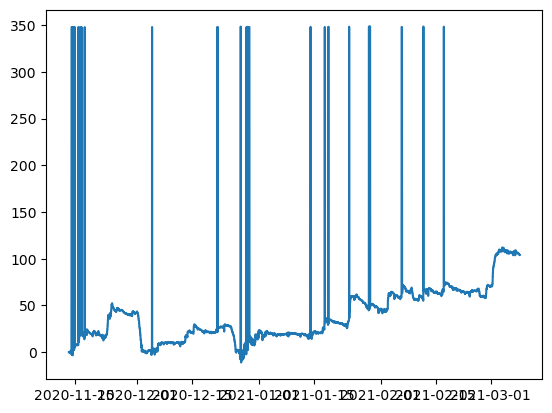

In [6]:
plt.plot(bd['SnowDepth'])

On remarque que des valeurs extrêmes qui représentent la hauteur du sensor sur le terrain. Il afficher sa hauteur lors de tempête neige (cristaux de neige en suspension. 

Ces valeurs sont faciles à traiter. On va faire un test de conditions avec une valeur plus petite que la hauteur mais plus haute que nos valeurs d'hauteur de neige. On remplace ces valeurs par None (NA).

Ensuite, On va remplir ces Na values par une méthode appelée "forward fill" (ffill).
Cette méthode prend la dernière valeur qui n'est pas un Na et l'a met "en avant".

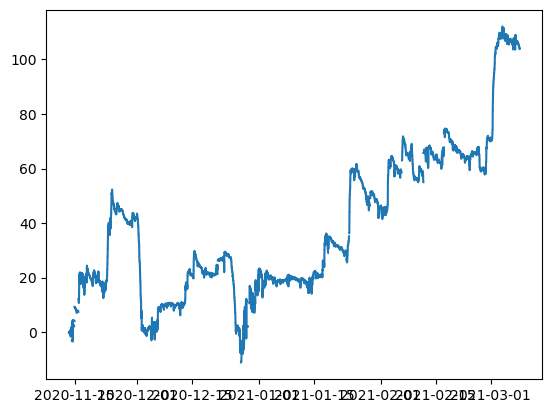

In [7]:
bd.loc[bd['SnowDepth']>250]= None
# On refait le graphique pour visualiser le résultat
plt.plot(bd['SnowDepth'])

In [8]:
bd.loc[bd['SnowDepth']>250]= None
bd = bd.fillna(method='ffill')

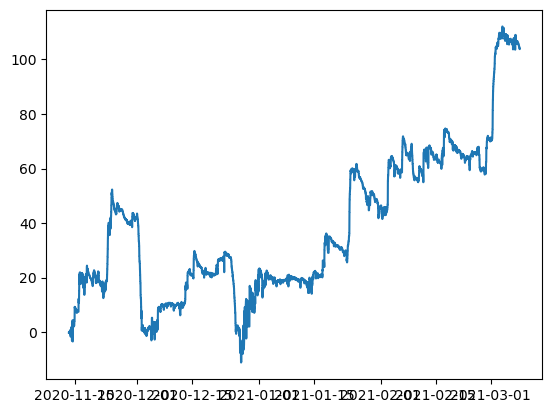

In [9]:
# On refait le graphique pour visualiser le résultat
plt.plot(bd['SnowDepth'])

## Rééchantillonnage
Pour l'étape suivante, on veut rééchantillonner nos données de 15 min vers une données aux 6h.
L'opération se fait facilement avec pandas. Cependant, on va appliquer une moyenne à l'ensemble des colonnes de notre dataframe.
Est-ce une bonne idée?

In [10]:
bd_hr = bd.resample('6H').mean()

## Séparation du dataframe pour validation croisé
Pour les analyses de séries temporelles, on veut entrainer nos modèles sur des données et prédire les valeurs "futures".
Ces prédictions sont appelées "out-of-sample prédiction". 

Pour savoir si c'est prédictions sont bonnes, il faut diviser notre dataframe en deux pour avoir une portion qui va permettre de valider nos prédictions.
Cette méthode est appelée la validation croisée ou Cross-validation.

In [11]:
bd_test = bd_hr[:'2021-03-01 12:00:09'] # le : signifie jusqu'au début si il est placé devant
bd_valid = bd_hr['2021-03-01 12:00:09':] # le : signifie jusqu'à la si il est placé derrière

bd_test = bd_test.asfreq(pd.infer_freq(bd_test.index)) # on spécifie la fréquence du dataframe dans pandas pour qu'il sache l'écart temporel dans les données
bd_valid = bd_valid.asfreq(pd.infer_freq(bd_valid.index))


## Air_temp
La première variable que nous allons testé est la température de l'air.
Il faut toujours commencer par une inspection visuelle. C'est l'analyse la plus efficace!!

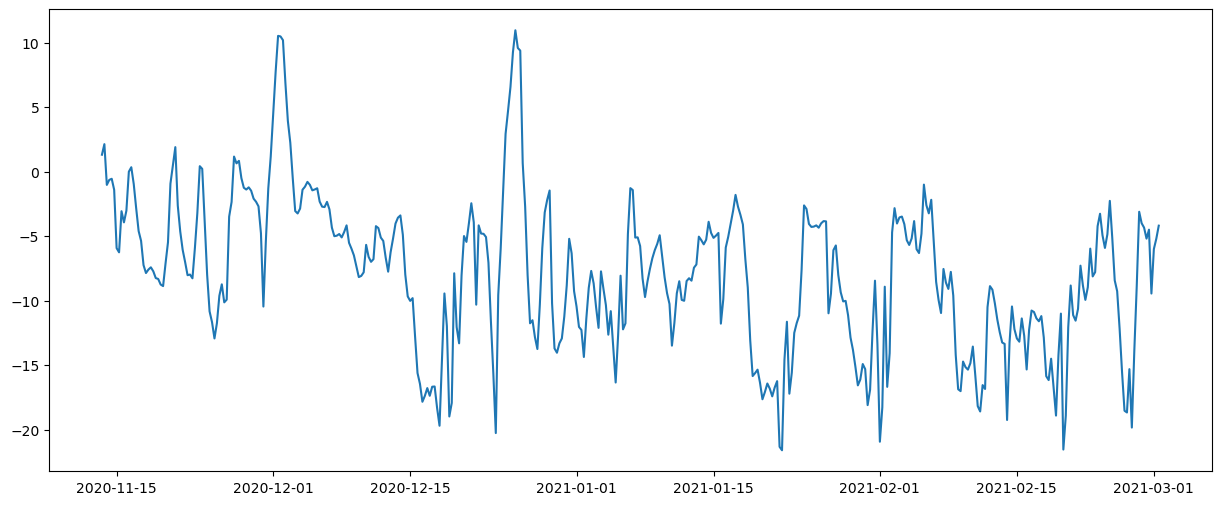

In [12]:
plt.figure(figsize = (15,6)) # spécifie la grosseur de la figure pour mieux voir
plt.plot(bd_test['AirTemp'])

Visuellement on voit que les température se refroidit un peu avant de se stabiliser.
Il y a donc plus au moins de tendance, ni de saisonnalité... mais allons voir l'ACF

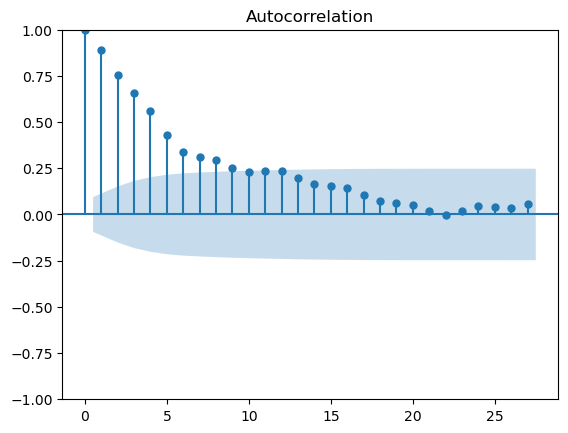

In [13]:
acf_plot = plot_acf(bd_test['AirTemp'])

Légère tendance mais ça diminue rapidement, Si on avait pas rééchantilloner et garder au 15min. 
On aurait une énorme autocorrélation dans nos données et nos modèles n'aurait pas fonctionné.

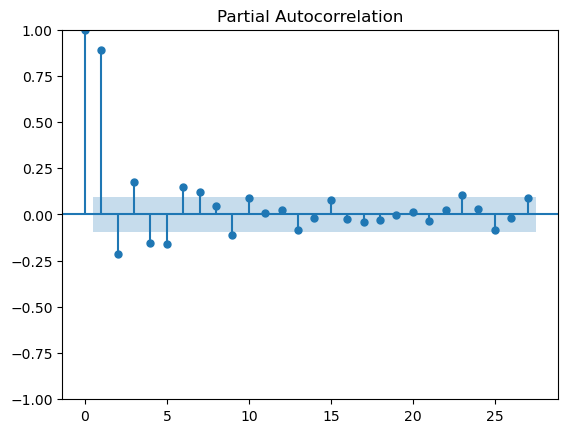

In [14]:
pacf_plot = plot_pacf(bd_test['AirTemp'])

La Pacf montre quelques lag significatifs mais sans plus... ça regarde bien pour notre AR!!

## Fit a ARIMA model
Nous allons utiliser la fonction auto_arima pour fitter nos ordres. 
Cette fonction utiliser l'AIC en step-wise pour trouver les meilleurs ordres possibles dans notre modèle.
Vous remarquerez que j'utilise un ARIMA mais je n'ai pas vraiment de tendance. Il n'y a pas de auto_arma.

On se souvient qu'un ARIMA a trois paramètres p, d et q
    p: ordre d'un AR
    d: ordre de la différenciation (tendance)
    q: ordre d'un MA

Si on ne veut pas d'intégration car on ne suspecte pas de tendance, on met d=None

In [28]:
model_autofit = pm.auto_arima(bd_test['AirTemp'], start_p = 1, start_q =1,
                             test = 'adf',
                             d=1, # on ne suspecte pas de tendance
                             seasonal=False,
                             start_P = 0,
                             D=0,
                             trace=True, # on veut voir les essais avec l'AIC et le temps de computation
                             stepwise=True)
print(model_autofit.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2070.637, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2090.704, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2082.872, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2075.014, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2088.714, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2060.251, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2060.350, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2059.580, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2058.061, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2057.233, Time=0.14 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2037.039, Time=0.21 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2024.079, Time=0.51 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2050.630, Time=0.29 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : 

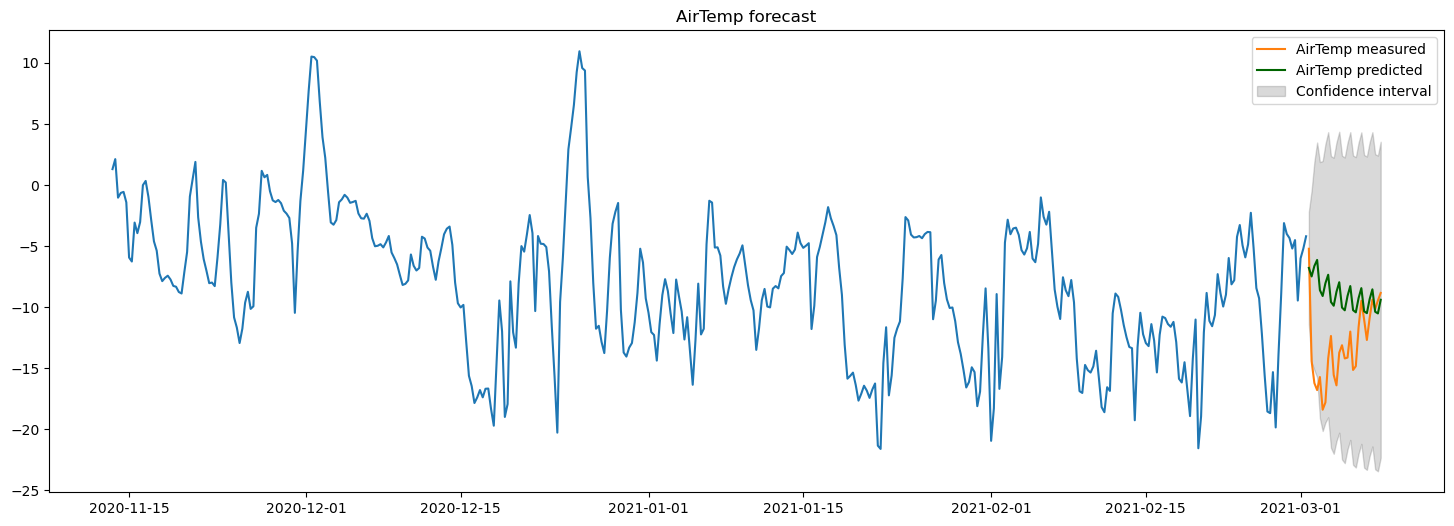

In [29]:
n_periods = len(bd_valid) # Je obtenir la longeur de mon dataframe de validation car je veux prédire le même temps (n_periods)
predictions_air, confint = model_autofit.predict(n_periods, return_conf_int=True)

# transformer mes list en PD.Series pour le graphiques
# si je ne fais pas cette étape, je vais me retrouver  avec un index numérique au lieu de date dans mon graphique
predictions_air = pd.Series(predictions_air, index=bd_valid.index)
lower_series = pd.Series(confint[:, 0], index=bd_valid.index)
upper_series = pd.Series(confint[:, 1], index=bd_valid.index)

# Plot
plt.figure(figsize=(18,6))
plt.plot(bd_test['AirTemp'])
plt.plot(bd_valid['AirTemp'], label = "AirTemp measured")
plt.plot(predictions_air, color='darkgreen', label = 'AirTemp predicted')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 label = 'Confidence interval',
                 color='k', alpha=.15,)
plt.legend()
plt.title("AirTemp forecast")
plt.show()

On voit que le modèle ne capture par les changements brusques de température, ils sont considérés ici comme "aléatoire". Le modèle capture l'oscillation de la température vers sa moyenne. 

Ce refroidissement n'est pas réaliste puisqu'on sait que la température doit plutôt se réchauffer en mars. Le dataset n'est donc pas assez grand pour que le modèle apprenne que le température se réchauffe en mars.

La prochaine étape est de mettre en graphique les résidus ou l'erreur de prédiction et de calcule notre RMSE et MAPE.

RMSE : Root mean square error

MAPE : Mean absolute percentage error

Mape: 0.3972538591624249
RMSE: 6.490721835382094


Text(0, 0.5, 'Temperature °C')

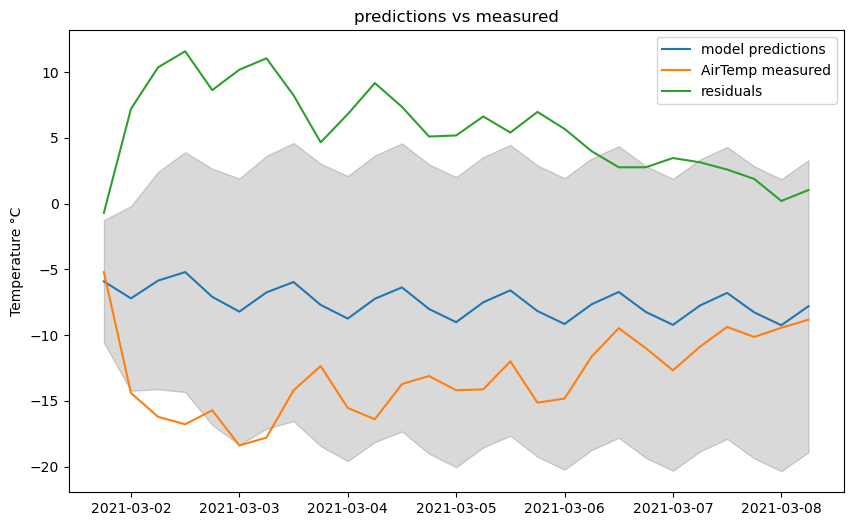

In [27]:
residuals = predictions_air-bd_valid['AirTemp'] 

Mape = np.mean(np.abs(predictions_air -bd_valid['AirTemp'])/np.abs(bd_valid['AirTemp']))
rmse = np.mean((predictions_air - bd_valid['AirTemp'])**2)**.5 
print('Mape:',Mape)
print('RMSE:',rmse)

plt.figure(figsize = (10,6))
plt.plot(predictions_air, label = "model predictions")
plt.plot(bd_valid['AirTemp'], label = "AirTemp measured")
plt.plot(residuals, label = "residuals")
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend()
plt.title("predictions vs measured")
plt.ylabel("Temperature °C")

En regardant notre RMSE et notre MAPE, on en déduit que notre modèle est pas très bon. 
La température de l'air est relativement difficile à prévoir à cette fréquence (6hr)

## SWI
On essaye avec une variable différente. La radiation solaire incidente.

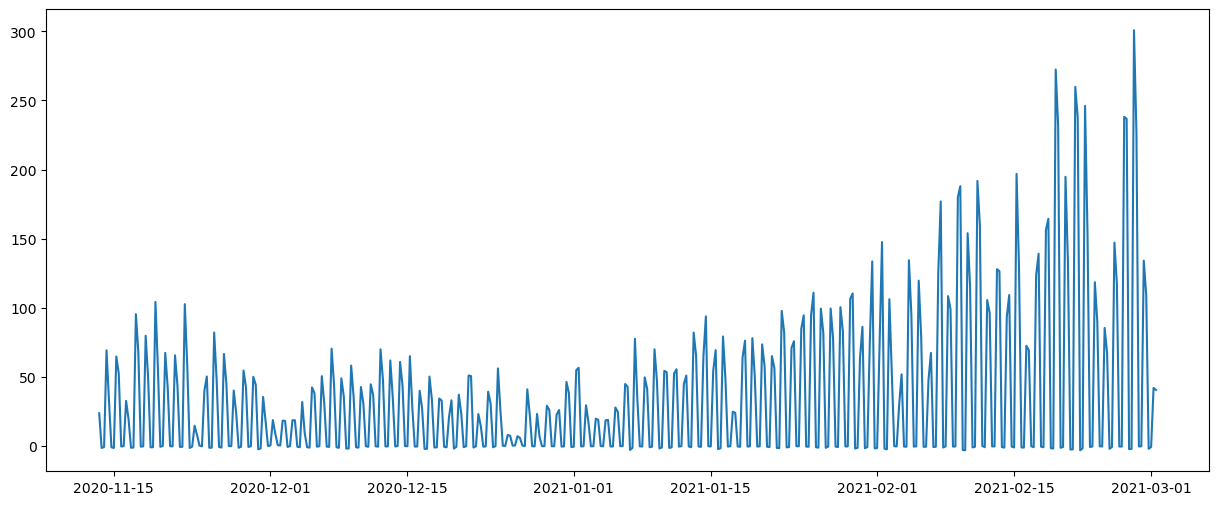

In [104]:
plt.figure(figsize = (15,6))
plt.plot(bd_test['SW-IN'])

Que remartque-t-on?

La série semble avoir une périodicité journalière et peut-etre une moyenne qui augmente vers la fin?

Allons voir l'ACF

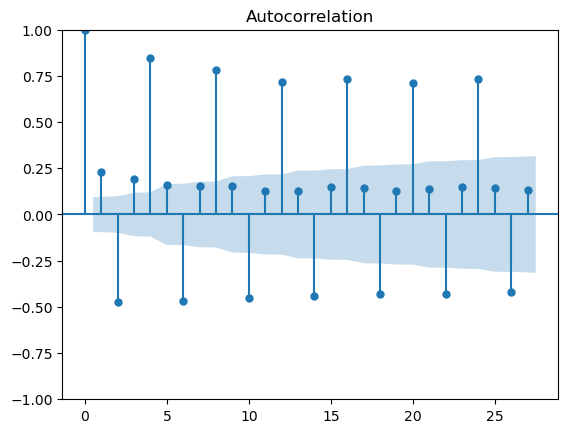

In [105]:
acf_plot = plot_acf(bd_test['SW-IN'])

On remarque sur l'ACF que le lag 4,8,12,16 et 24 sont siginificatifs. Pourquoi?

Si on revient à notre série temporelle, nos données ont été rééchantillonées aux 6heures. Un lag correspond donc à 6h.

À quoi correspond le lag 4? le lag 8?

Il y 6h dans un lag donc le lag 4 correspond à 24h, d'où notre saisonnalité ou périodicité journalière. Il va falloir en tenir compte dans notre forecasting.


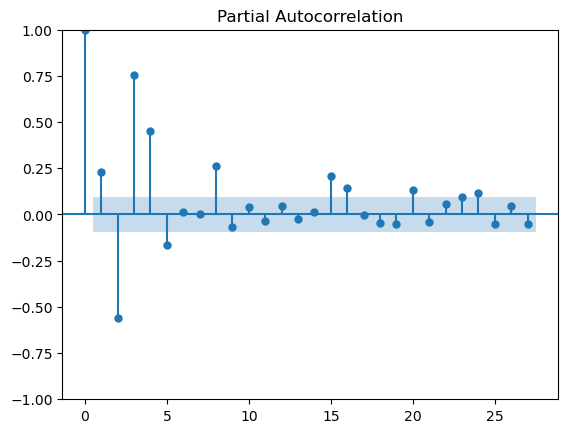

In [106]:
pacf_swi = plot_pacf(bd_test['SW-IN'])

## Autofit de notre modèle SARIMA
On comprend qu'il faut intégrer la composante saisonnière (journalière dans notre cas) pour prédire le radiation solaire incidente.

On peut l'intégrer en utilisant un modèle SARIMA qui se définit ainsi:

    ARIMA (p,d,q)x(P,D,Q)m
    p,d,q sont nos paramètres non-saisonnier
    P,D,Q sont nos paramètres saisonniers
    m est le nombre de lag de notre période saisonnière.
    
Dans notre cas, nous avons des données aux 6hr donc un lag 6 et une période saisonnière de 24h donc m=4

In [107]:
smodel_autofit = pm.auto_arima(bd_test['SW-IN'], start_p = 1, start_q =1,
                             test = 'adf',
                             d=None,
                              m=4, # fréquence PRIMORDIALE pour une bonne différenciation saisonnière (dans notre cas journalière
                             seasonal=True, # on change pour TRUE
                             start_P = 0,
                             D=1, # on force D à 1 pour une différenciation saisonnière d'ordre 1
                             trace=True,
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[4] intercept   : AIC=3918.948, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=4129.277, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=4024.114, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=3917.683, Time=0.72 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=4127.278, Time=0.05 sec
 ARIMA(0,0,1)(0,1,0)[4] intercept   : AIC=4034.379, Time=0.17 sec
 ARIMA(0,0,1)(1,1,1)[4] intercept   : AIC=3904.393, Time=0.52 sec
 ARIMA(0,0,1)(1,1,0)[4] intercept   : AIC=3986.995, Time=0.34 sec
 ARIMA(0,0,1)(2,1,1)[4] intercept   : AIC=3904.834, Time=1.47 sec
 ARIMA(0,0,1)(1,1,2)[4] intercept   : AIC=3905.905, Time=1.83 sec
 ARIMA(0,0,1)(0,1,2)[4] intercept   : AIC=3904.624, Time=1.13 sec
 ARIMA(0,0,1)(2,1,0)[4] intercept   : AIC=3980.620, Time=1.25 sec
 ARIMA(0,0,1)(2,1,2)[4] intercept   : AIC=3903.001, Time=2.24 sec
 ARIMA(0,0,0)(2,1,2)[4] intercept   : AIC=4002.524, Time=2.24 sec
 ARIMA(1,0,1)(2,1,2)[4] intercept

In [108]:
smodel_autofit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  433
Model:             SARIMAX(1, 0, 1)x(2, 1, [1, 2], 4)   Log Likelihood               -1942.246
Date:                                Fri, 24 Nov 2023   AIC                           3900.492
Time:                                        12:40:46   BIC                           3932.983
Sample:                                    11-13-2020   HQIC                          3913.323
                                         - 03-01-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6812      0.636      1.070      0.285      -0.566       1.929
ar.L1         -0.1786      0.075     -2.390      0.017      -0.325      -0.032
ma.L1          0.7017      0.058     12.075      0.000       0.588       0.816
ar.S.L4       -0.5523      0.081     -6.839      0.000      -0.711      -0.394
ar.S.L8        0.3069      0.036      8.491      0.000       0.236       0.378
ma.S.L4       -0.0372      0.079     -0.473      0.636      -0.192       0.117
ma.S.L8       -0.7298      0.063    -11.658      0.000      -0.852      -0.607
sigma2       495.9249     17.675     28.058      0.000     461.282     530.567
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1071.51
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               7.58   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

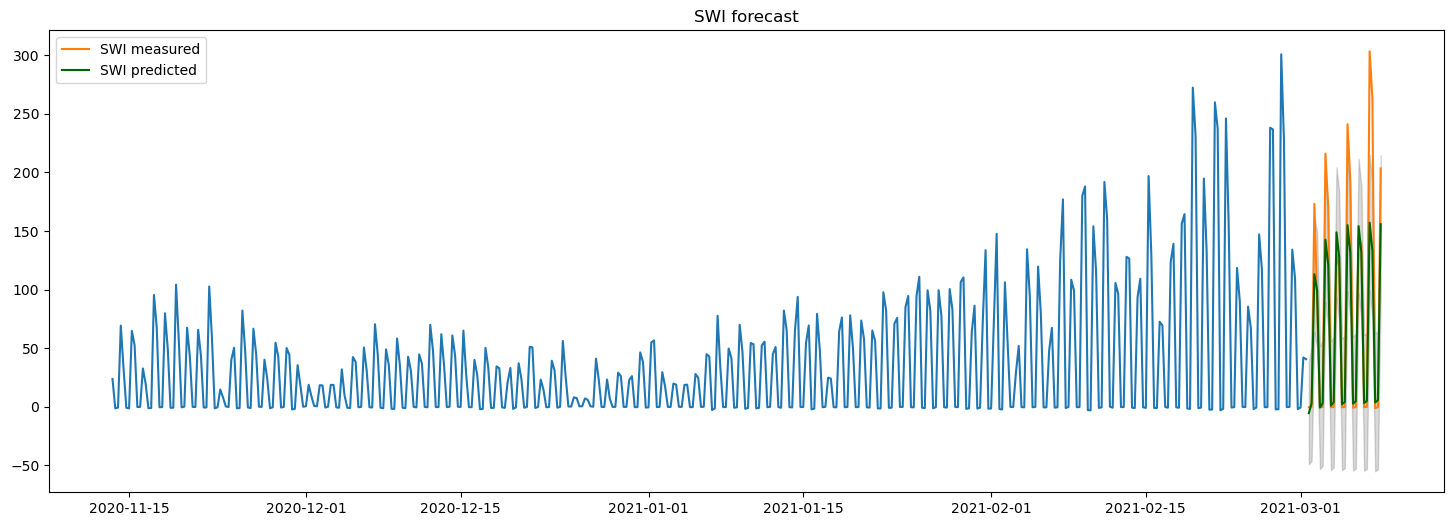

In [109]:
n_periods = len(bd_valid['SW-IN'])
predictions_swi, confint = smodel_autofit.predict(n_periods, return_conf_int=True) 

# transformer mes list en PD.Series pour le graphiques
# si je ne fais pas cette étape, je vais me retrouver  avec un index numérique au lieu de date dans mon graphique
predictions_swi = pd.Series(predictions_swi, index=bd_valid.index)
lower_series = pd.Series(confint[:, 0], index=bd_valid.index)
upper_series = pd.Series(confint[:, 1], index=bd_valid.index)

# Plot
plt.figure(figsize=(18,6))
plt.plot(bd_test['SW-IN'])
plt.plot(bd_valid['SW-IN'], label = "SWI measured")
plt.plot(predictions_swi, color='darkgreen', label = 'SWI predicted')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.legend()
plt.title("SWI forecast")
plt.show()

Mes données prédites semblent faire du sens visuellement! Le modèle capture bien le cycle journalier de radiation solaire et la moyenne semble augmenter comme dans les données.

La prochaine étape est de mettre en graphique les résidus ou l'erreur de prédiction et de calcule notre RMSE et MAPE:

RMSE : Root mean square error

MAPE : Mean absolute percentage error

Mape: 5.230952805204721
RMSE: 48.747393965145044


Text(0, 0.5, 'Incoming radiation W/m^2')

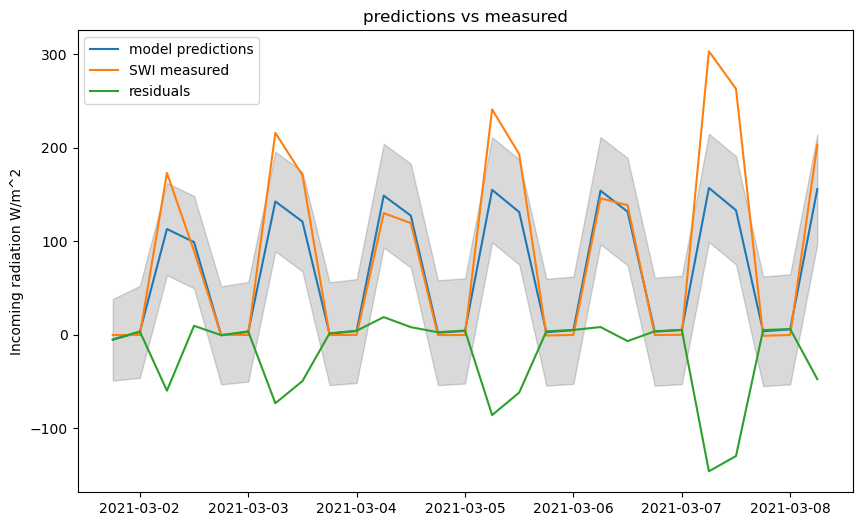

In [110]:
residuals = predictions_swi-bd_valid['SW-IN']

Mape = np.mean(np.abs(predictions_swi-bd_valid['SW-IN'])/np.abs(bd_valid['SW-IN']))
rmse = np.mean((predictions_swi - bd_valid['SW-IN'])**2)**.5 
print('Mape:',Mape)
print('RMSE:',rmse)

plt.figure(figsize = (10,6))
plt.plot(predictions_swi, label = "model predictions")
plt.plot(bd_valid['SW-IN'], label = "SWI measured")
plt.plot(residuals, label ='residuals')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend()
plt.title("predictions vs measured")
plt.ylabel("Incoming radiation W/m^2")


YESSIR MILLER!

On a obtenu une erreur de 5% avec une RMSE de 48W/m2 ce qui est pas si pire compte de l'étendue de valeur de radiation.

Le SARIMA a vraiment mieux fonctionné avec les données de radiation solaire car la série contenait des éléments plus facile à modéliser et moins aléatoire.